# Introduction

In this notebook we will evaluate the Velib prediction model

## What is Velib ?

Velib is a public bicycle sharing system in Paris, France. It encompasses around 14500 bicycles and 1400 bicycles stations located across Paris and some surroundinf municipalities.

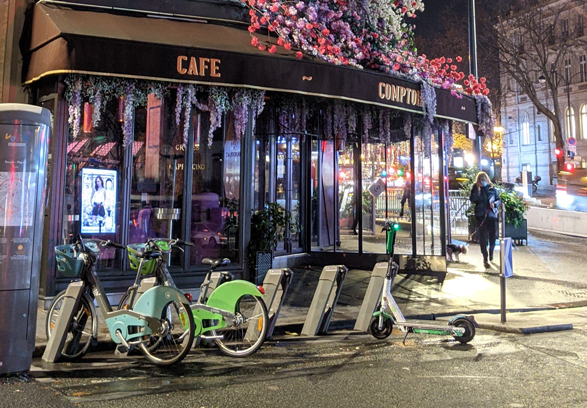

## Velib application on the play store

There is an official Vélib application on the playstore that allows the users to consult the stations map and the availability of the bicycles on each station.
Recently Velib added a new feature on this application which allows to see the prediction of the number of available bicycles and free docks on each station for the next 30 and 60 minutes.


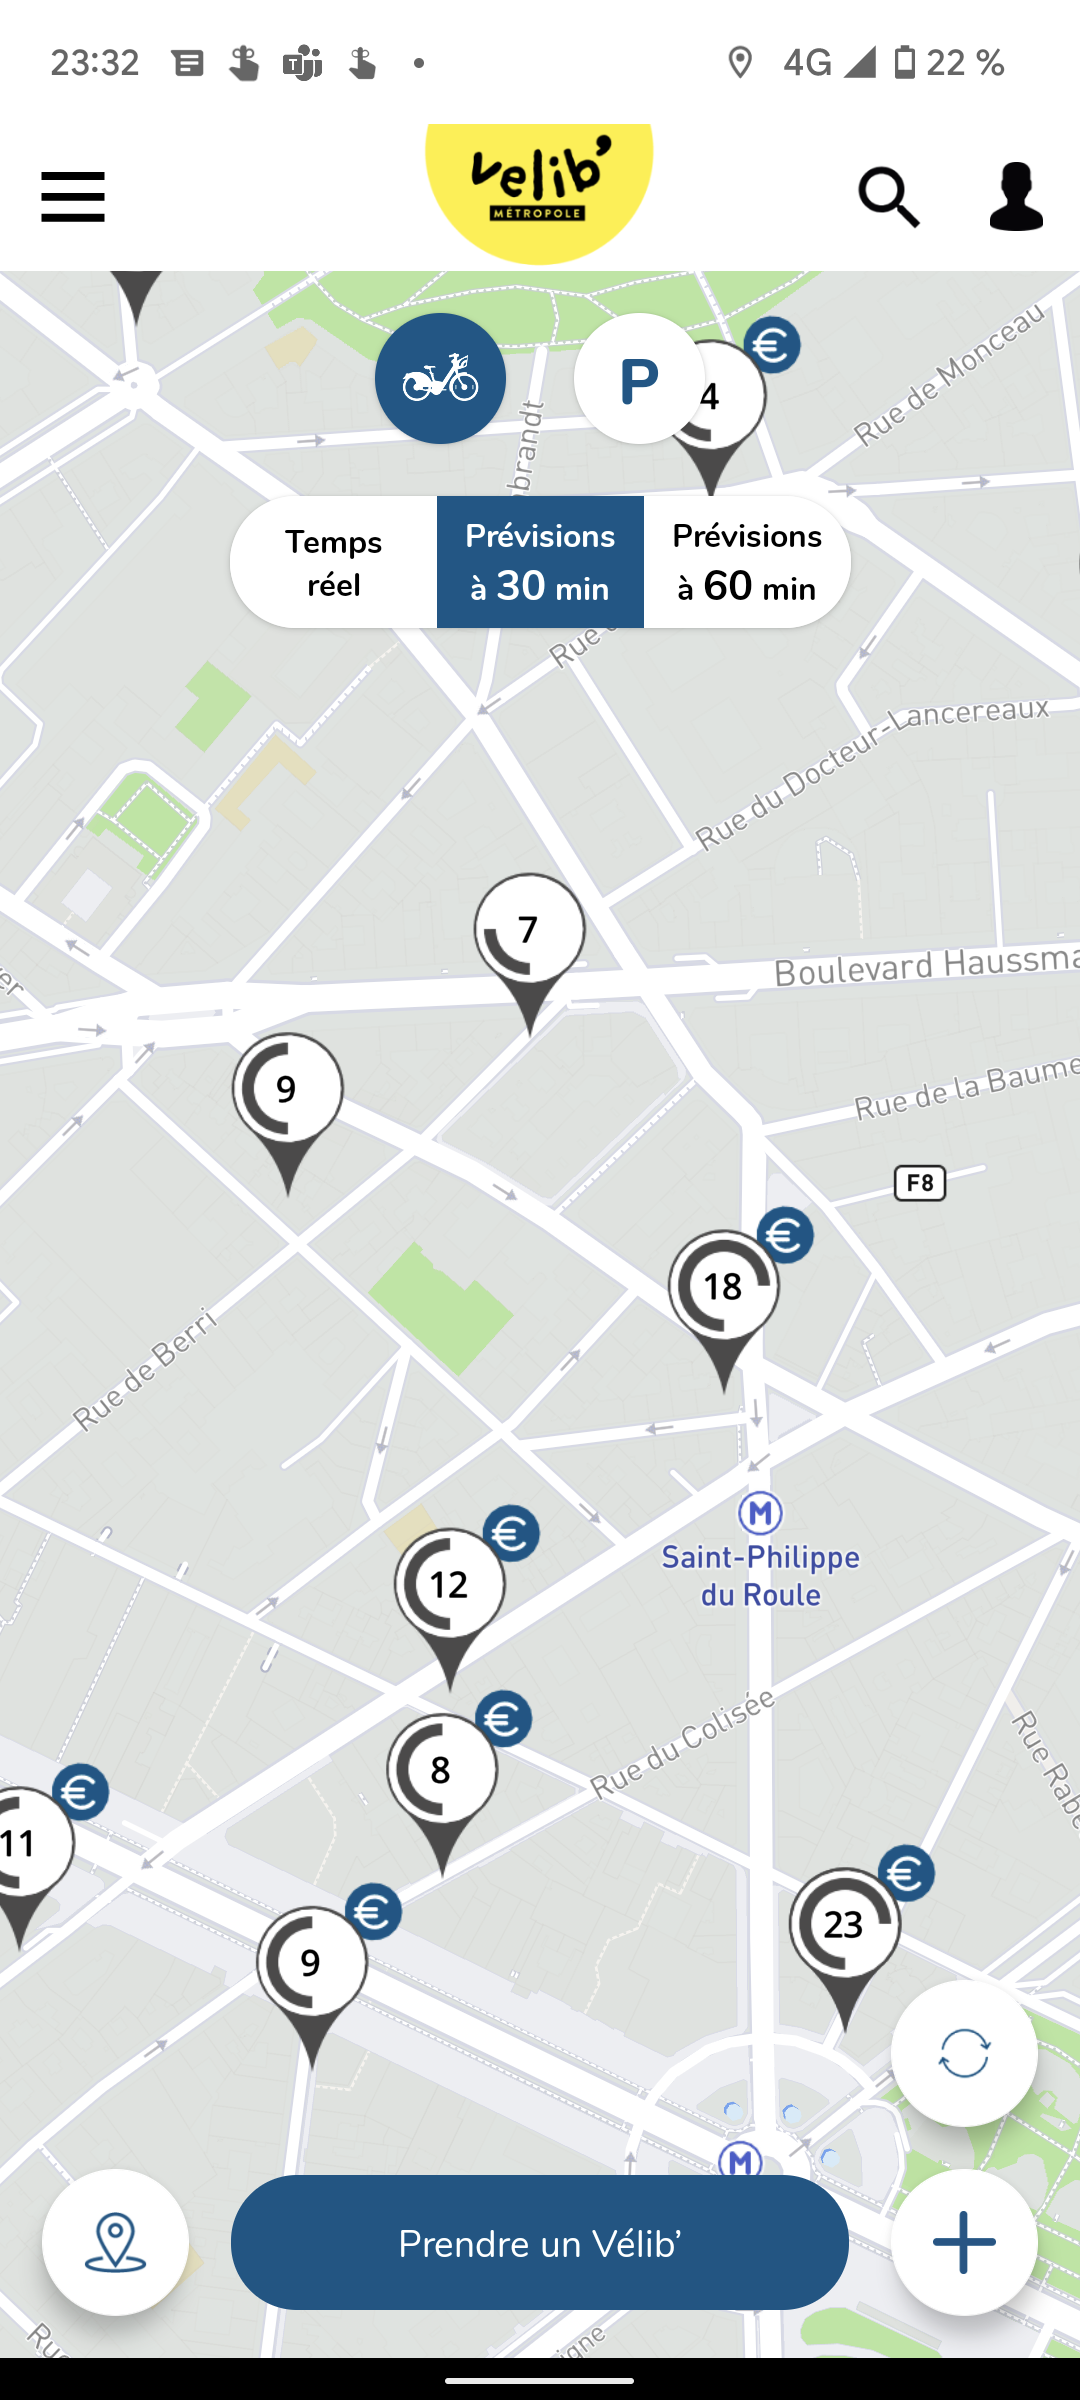

The goal of this notebook is to evaluate the accuracy of the model used by Vélib to predict the number of available bicycles and free docks in the next minutes.

## How to get the data ?

### The real time data API

In order to collect the data that we are going to work on, we should get access to the Vélib API.
The real time API is public, it is also used on the Vélib website : https://www.velib-metropole.fr/map#/ in order to show the availibility of bicycles on a map.
By inspecting element on your browser you can find in the netweork tab the API that was requested in order to get the data.

Here is the link to the real time availability API : https://www.velib-metropole.fr/webapi/map/details?gpsTopLatitude=48.85644665702719&gpsTopLongitude=2.3515371188657355&gpsBotLatitude=48.853471823504236&gpsBotLongitude=2.3436400067155034&zoomLevel=16.094697704744164

You can change the zone you want to have the data about by changing the top and bottom lattitude and longitude parameters in the request

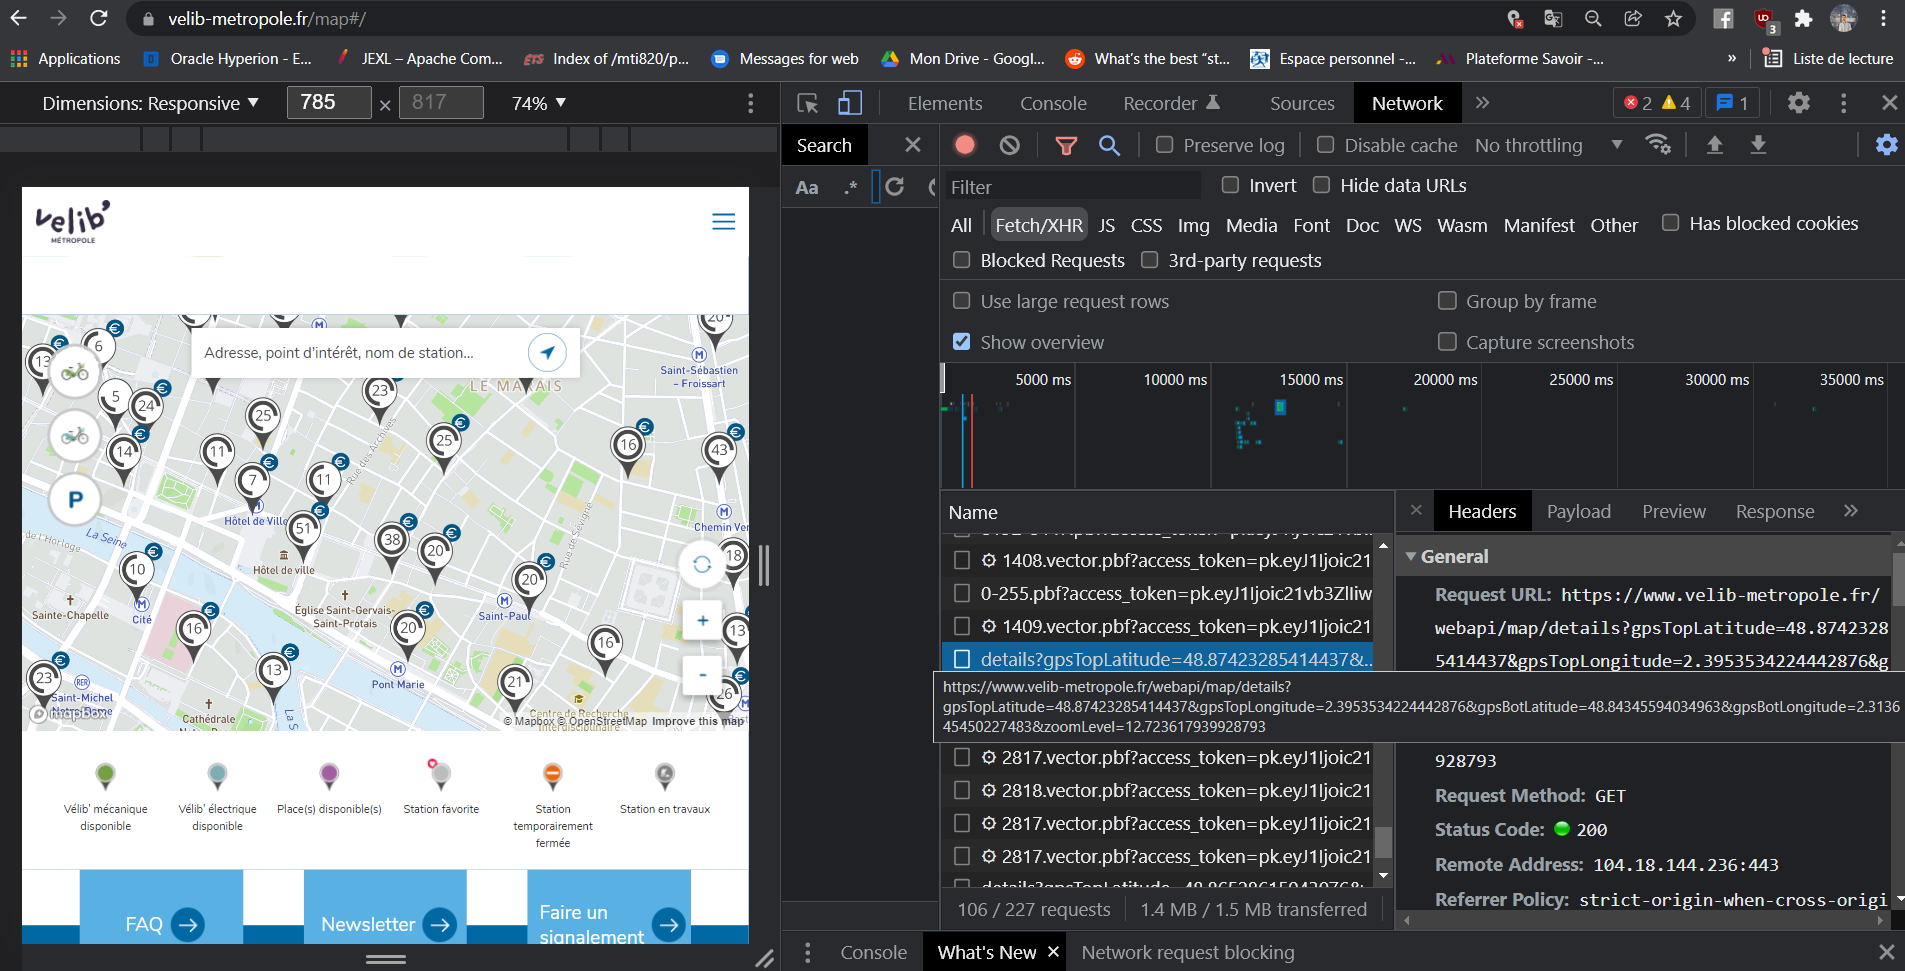

### The availability prediction API

On the Vélib Android application the API that serves the predictions data is used. By making some requests capturing while using the application you can get the link to this API and its token.
I used a tool called Burp Suite in order to intercept the requests made by the application, both the computer and the phone should be connected to the same Wifi hotspot.

The API is something like : https://api.qucit.com/bikepredict/v3/systems/17/occupations .
I can let you find the token.

### Examples

You can find in the file examples/details.json an example of the json response of the real time data API

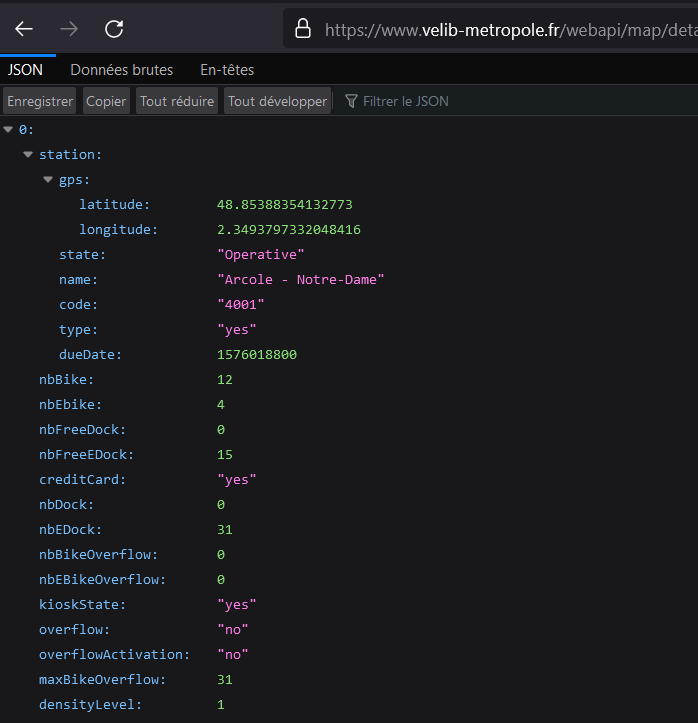

We can read on the json response that there was 12 bikes, 4 electric bikes, 0 free normal dock and 15 free electric docks at the moment whe the request was made.

You can find in the file examples/predictions.json an example of the json response of the in 60 minutes prediction API

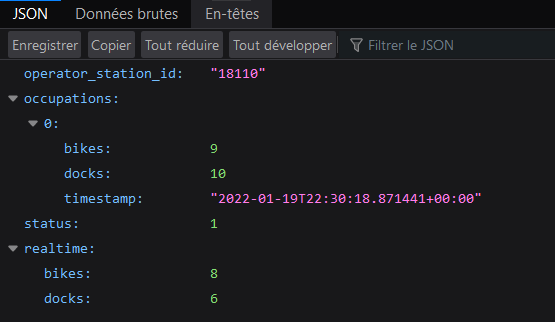

We can read on this json response that there will be 9 available bikes and 10 free docks on the station wich id is 18110 instead of 8 bikes and 6 free docks currently.

# Collecting the data

Now that we've gotten used to the Vélib API, we are going to automate the collection of the real time number of free bikes and free dock and the predected numbers every 10 minutes during a 1 day.

As the Vélib API returns also some data about the adress of the station, density level, latitude and longitude, ... We are going to focus only on the following attributes : **code, nbBike, nbEbike, nbFreeDock, nbFreeEDock**

### Real time data

The following code allows to request the API every 10 min and  write the availability data in a CSV file

In [ ]:
import csv
import requests
import json
import time
from datetime import datetime


def getData():
    headers = {
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        "accept-language": "fr,en-US;q=0.9,en;q=0.8,ar;q=0.7,fr-FR;q=0.6,ar-MA;q=0.5",
        "cache-control": "max-age=0",
        "sec-ch-ua": "\" Not;A Brand\";v=\"99\", \"Google Chrome\";v=\"97\", \"Chromium\";v=\"97\"",
        "sec-ch-ua-mobile": "?1",
        "sec-ch-ua-platform": "\"Android\"",
        "sec-fetch-dest": "document",
        "sec-fetch-mode": "navigate",
        "sec-fetch-site": "none",
        "sec-fetch-user": "?1",
        "upgrade-insecure-requests": "1",
        "cookie": "tarteaucitron=!gtag=true!googletagmanager=true!recaptcha=true!youtube=true; ApplicationGatewayAffinityCORS=0e6278228d2a59543f2d40831e3a1913; ApplicationGatewayAffinity=0e6278228d2a59543f2d40831e3a1913; dtCookie=v_4_srv_2_sn_A831EFD18DEBA8989C13FC09216278FF_perc_100000_ol_0_mul_1_app-3A707e3a456ac14761_1; __cf_bm=CR4xQSaLKp2BwY3XEYGt7D78A4Iql3GDl9622UelJXw-1642465887-0-AcxX33LbFfdthMj5JcI82vRCJWxZ+YQT9a2Tfs6dHilVWyRPdXtp8hgv0zuFqArMFFsB0uPHEHmwDkaWKHmhnm8="
    }
    try:
        response = requests.get(
            'https://www.velib-metropole.fr/webapi/map/details?gpsTopLatitude=48.947193&gpsTopLongitude=2.486898&gpsBotLatitude=48.790996&gpsBotLongitude=2.137815&zoomLevel=17',
            headers=headers)
        return response
    except:
        print("ok")


starttime = time.time()
while True:
    timestamp = time.time()
    dt_object = datetime.fromtimestamp(timestamp)
    fileName = "realNumbers_" + dt_object.strftime("%d-%m-%Y_%H%M") + ".csv"
    f = open(fileName, "a")
    f.write("stationCode;date;nbBike;nbEbike;nbFreeDock;nbFreeEDock\n")
    f.close()

    response = getData()

    if response.status_code != 500:
        print(response.status_code)
        responseJson = response.json()
        # print(responseJson)
        for thisStation in responseJson:
            stationCode = thisStation["station"]["code"]
            nbBike = thisStation["nbBike"]
            nbEbike = thisStation["nbEbike"]
            nbFreeDock = thisStation["nbFreeDock"]
            nbFreeEDock = thisStation["nbFreeEDock"]
            line = str(stationCode) + ";" + dt_object.strftime("%Y-%m-%d %H:%M:%S") + ";" + str(nbBike) + ";" + str(
                nbEbike) + ";" + str(nbFreeDock) + ";" + str(nbFreeEDock) + "\n"
            f = open(fileName, "a")
            f.write(line)
            f.close()
        time.sleep(600.0 - ((time.time() - starttime) % 600.0))

### Predicted data

The following code allows to ask the 30 minutes prediction API every 10 min and  writes the retuned data in a CSV file

In [ ]:
import requests
import time
import json
from datetime import datetime
from datetime import timedelta
def get30MinutesPredictions() :
    headers = {
        'Connection': 'close',
        'X-Authentication-Domain': 'smovengo-velib-paris',
        'User-Agent': 'okhttp/3.12.12',
    }

    params = (
        ('timestamp', 'in-30-minutes'),
    )
    response = requests.get('https://api.qucit.com/bikepredict/v3/systems/17/occupations', headers=headers, params=params, auth=('EMAIL_HERE', 'PASSWORD_HERE'))
    if response.status_code != 500:
        responseJson = response.json()
        print(responseJson["data"][0])
        timestamp = time.time()
        dt_object = datetime.fromtimestamp(timestamp)
        # Since it's a 30 minutes prediction we should name the file with current time + 30 minutes
        final_time = dt_object + timedelta(minutes=30)
        fileName = "predictions_30min_" + final_time.strftime("%d-%m-%Y_%H%M") + ".csv"
        f = open(fileName, "a")
        f.write("stationCode;date;nbBikes;nbDocks\n")
        f.close()
        f = open(fileName, "a")
        for i in range(len(responseJson["data"])) :
            stationId = responseJson["data"][i]["operator_station_id"]
            nbBikes = responseJson["data"][i]["occupations"][0]["bikes"]
            nbDocks = responseJson["data"][i]["occupations"][0]["docks"]
            line = str(stationId) + ";" + dt_object.strftime("%Y-%m-%d %H:%M:%S") + ";" + str(nbBikes) + ";" + str(nbDocks) + "\n"
            f.write(line)
        f.close()
starttime = time.time()
while True:
    try :
        get30MinutesPredictions()
        time.sleep(600.0 - ((time.time() - starttime) % 600.0))
    except :
        print("Exception")
        time.sleep(10.0 - ((time.time() - starttime) % 10.0))



The following code allows to ask the 60 minutes prediction API every 10 min and  writes the retuned data in a CSV file

In [ ]:
import requests
import time
import json
from datetime import datetime
def get60MinutesPredictions() :
    headers = {
        'Connection': 'close',
        'X-Authentication-Domain': 'smovengo-velib-paris',
        'User-Agent': 'okhttp/3.12.12',
    }

    params = (
        ('timestamp', 'in-60-minutes'),
    )
    response = requests.get('https://api.qucit.com/bikepredict/v3/systems/17/occupations', headers=headers, params=params, auth=('EMAIL_HERE', 'PASSWORD_HERE'))
    if response.status_code != 500:
        responseJson = response.json()
        print(responseJson["data"][0])
        timestamp = time.time()
        dt_object = datetime.fromtimestamp(timestamp)
        # Since it's a 60 minutes prediction we should name the file with current time + 30 minutes
        final_time = dt_object + timedelta(minutes=60)
        fileName = "predictions_60min_" + final_time.strftime("%d-%m-%Y_%H%M") + ".csv"
        f = open(fileName, "a")
        f.write("stationCode;date;nbBikes;nbDocks\n")
        f.close()
        f = open(fileName, "a")
        for i in range(len(responseJson["data"])) :
            stationId = responseJson["data"][i]["operator_station_id"]
            nbBikes = responseJson["data"][i]["occupations"][0]["bikes"]
            nbDocks = responseJson["data"][i]["occupations"][0]["docks"]
            line = str(stationId) + ";" + dt_object.strftime("%Y-%m-%d %H:%M:%S") + ";" + str(nbBikes) + ";" + str(nbDocks) + "\n"
            f.write(line)
        f.close()
starttime = time.time()
while True:
    try :
        get60MinutesPredictions()
        time.sleep(600.0 - ((time.time() - starttime) % 600.0))
    except :
        print("Exception")
        time.sleep(10.0 - ((time.time() - starttime) % 10.0))

### Letting the code run for a while

In order to collect enough data to evaluate the prediction model of Velib, we should let the 3 above scripts running for a while (24 hours). <br> Don't leave these scripts running for a long time, Velib won't be happy with that.

# And what now?

When reaching this stage, we should normally have about 1440 files of real time data, 1440 files of 30 minutes prdictions and 1440 of 60 minutes predictions. <br> This is what each of the files looks like

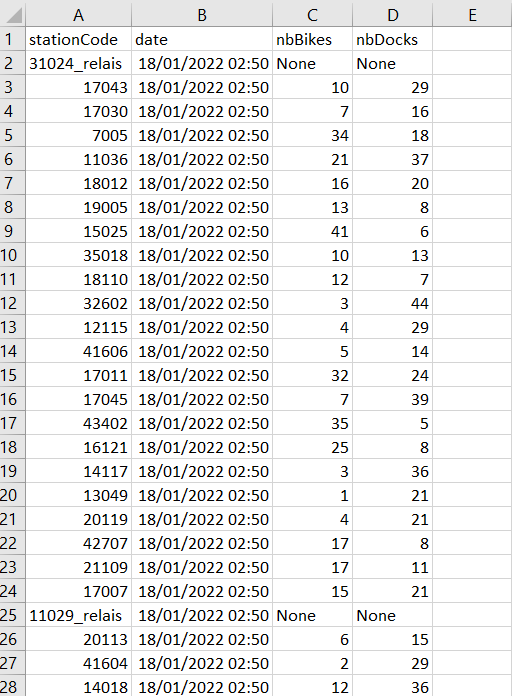

# Evaluating the model

## MAE

In order to evaluate the Velib prediction model, we are going to use a metric called : MAE (Mean absolute error)

In statistics, **mean absolute error (MAE)** is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. MAE is calculated as :

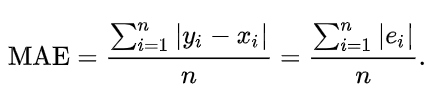

In [14]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
def evaluateNbBikesPredictionMare(fileName):
    df = pd.read_csv("data/predictions_60min_" + fileName + ".csv", sep=";")
    df.sort_values(by="stationCode")
    bikesPred30 = df[["stationCode", "nbBikes"]].copy()
    bikesPred30 = bikesPred30[bikesPred30.nbBikes != "None"]
    dfRealTime = pd.read_csv("data/realNumbers_" + fileName + ".csv", sep=";")
    dfRealTime.sort_values(by="stationCode")
    totalBikes = dfRealTime["nbBike"]+ dfRealTime["nbEbike"]
    dfRealTime["totalBikes"] = totalBikes
    bikesReal = dfRealTime[["stationCode", "totalBikes"]]
    dfMerge = bikesReal.merge(bikesPred30.drop_duplicates(), on=["stationCode"], how = 'left' ,indicator=True)
    dfMerge= dfMerge.dropna(subset=["nbBikes"])
    y_test = dfMerge["totalBikes"]
    y_predict = dfMerge["nbBikes"]
    mae = mean_absolute_error(y_test, y_predict)
    return mae

In [15]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
def evaluateNbFreeDocksPredictionMare(fileName):
    df = pd.read_csv("data/predictions_60min_" + fileName + ".csv", sep=";")
    df.sort_values(by="stationCode")
    freeDocksPred30 = df[["stationCode", "nbDocks"]].copy()
    freeDocksPred30 = freeDocksPred30[freeDocksPred30.nbDocks != "None"]
    dfRealTime = pd.read_csv("data/realNumbers_" + fileName + ".csv", sep=";")
    dfRealTime.sort_values(by="stationCode")
    totalFreeDocks = dfRealTime["nbFreeDock"]+ dfRealTime["nbFreeEDock"]
    dfRealTime["totalFreeDocks"] = totalFreeDocks
    freeDocksReal = dfRealTime[["stationCode", "totalFreeDocks"]]
    dfMerge = freeDocksReal.merge(freeDocksPred30.drop_duplicates(), on=["stationCode"], how = 'left' ,indicator=True)
    dfMerge= dfMerge.dropna(subset=["nbDocks"])
    y_test = dfMerge["totalFreeDocks"]
    y_predict = dfMerge["nbDocks"]
    mae = mean_absolute_error(y_test, y_predict)
    return mae

In [24]:
listOfHours = ["18-01-2022_1130", "18-01-2022_1140", "18-01-2022_1150", "18-01-2022_1200", "18-01-2022_1210", "18-01-2022_1220", "18-01-2022_1230", "18-01-2022_1240", "18-01-2022_1250", "18-01-2022_1300", "18-01-2022_1310", "18-01-2022_1320", "18-01-2022_1330", "18-01-2022_1340", "18-01-2022_1350", "18-01-2022_1400", "18-01-2022_1410", "18-01-2022_1420", "18-01-2022_1430", "18-01-2022_1440", "18-01-2022_1450", "18-01-2022_1500", "18-01-2022_1510", "18-01-2022_1520", "18-01-2022_1530", "18-01-2022_1540", "18-01-2022_1550", "18-01-2022_1600", "18-01-2022_1610", "18-01-2022_1620", "18-01-2022_1630", "18-01-2022_1640", "18-01-2022_1650", "18-01-2022_1700", "18-01-2022_1710", "18-01-2022_1720", "18-01-2022_1730", "18-01-2022_1740", "18-01-2022_1750", "18-01-2022_1800", "18-01-2022_1810", "18-01-2022_1820", "18-01-2022_1830", "18-01-2022_1840", "18-01-2022_1850", "18-01-2022_1900", "18-01-2022_1910", "18-01-2022_1920", "18-01-2022_1930", "18-01-2022_1940", "18-01-2022_1950", "18-01-2022_2000", "18-01-2022_2010", "18-01-2022_2020", "18-01-2022_2030", "18-01-2022_2040", "18-01-2022_2050", "18-01-2022_2100", "18-01-2022_2110", "18-01-2022_2120", "18-01-2022_2130", "18-01-2022_2140", "18-01-2022_2150", "18-01-2022_2200", "18-01-2022_2210", "18-01-2022_2220", "18-01-2022_2230"]
listofNbBikesPredictionMae = []
for thisHour in listOfHours :
    print(thisHour)
    mae = evaluateNbBikesPredictionMare(thisHour)
    print(mae)
    listofNbBikesPredictionMae.append(mae)

18-01-2022_1130
1.7635968092820884
18-01-2022_1140
1.6968817984046412
18-01-2022_1150
1.6751269035532994
18-01-2022_1200
1.7527193618564176
18-01-2022_1210
1.7556200145032632
18-01-2022_1220
1.7454677302393038
18-01-2022_1230
1.8629441624365481
18-01-2022_1240
1.9013778100072516
18-01-2022_1250
1.9274836838288616
18-01-2022_1300
1.9731689630166787
18-01-2022_1310
1.8977519941986947
18-01-2022_1320
1.8455402465554749
18-01-2022_1330
1.9289340101522843
18-01-2022_1340
1.9086294416243654
18-01-2022_1350
1.8622189992748368
18-01-2022_1400
1.9506889050036258
18-01-2022_1410
1.9289340101522843
18-01-2022_1420
1.9129804205946337
18-01-2022_1430
1.9361856417693981
18-01-2022_1440
1.92675852066715
18-01-2022_1450
1.8027556200145032
18-01-2022_1500
1.8694706308919506
18-01-2022_1510
1.7722987672226251
18-01-2022_1520
1.704133430021755
18-01-2022_1530
1.7222625090645396
18-01-2022_1540
1.6736765772298767
18-01-2022_1550
1.6163886874546773
18-01-2022_1600
1.732414793328499
18-01-2022_1610
1.750543

In [19]:
listOfHours = ["18-01-2022_1130", "18-01-2022_1140", "18-01-2022_1150", "18-01-2022_1200", "18-01-2022_1210", "18-01-2022_1220", "18-01-2022_1230", "18-01-2022_1240", "18-01-2022_1250", "18-01-2022_1300", "18-01-2022_1310", "18-01-2022_1320", "18-01-2022_1330", "18-01-2022_1340", "18-01-2022_1350", "18-01-2022_1400", "18-01-2022_1410", "18-01-2022_1420", "18-01-2022_1430", "18-01-2022_1440", "18-01-2022_1450", "18-01-2022_1500", "18-01-2022_1510", "18-01-2022_1520", "18-01-2022_1530", "18-01-2022_1540", "18-01-2022_1550", "18-01-2022_1600", "18-01-2022_1610", "18-01-2022_1620", "18-01-2022_1630", "18-01-2022_1640", "18-01-2022_1650", "18-01-2022_1700", "18-01-2022_1710", "18-01-2022_1720", "18-01-2022_1730", "18-01-2022_1740", "18-01-2022_1750", "18-01-2022_1800", "18-01-2022_1810", "18-01-2022_1820", "18-01-2022_1830", "18-01-2022_1840", "18-01-2022_1850", "18-01-2022_1900", "18-01-2022_1910", "18-01-2022_1920", "18-01-2022_1930", "18-01-2022_1940", "18-01-2022_1950", "18-01-2022_2000", "18-01-2022_2010", "18-01-2022_2020", "18-01-2022_2030", "18-01-2022_2040", "18-01-2022_2050", "18-01-2022_2100", "18-01-2022_2110", "18-01-2022_2120", "18-01-2022_2130", "18-01-2022_2140", "18-01-2022_2150", "18-01-2022_2200", "18-01-2022_2210", "18-01-2022_2220", "18-01-2022_2230"]
listofFreeDocksPredictionMae = []
for thisHour in listOfHours :
    print(thisHour)
    mae = evaluateNbFreeDocksPredictionMare(thisHour)
    print(mae)
    listofFreeDocksPredictionMae.append(mae)

18-01-2022_1130
2.3096446700507616
18-01-2022_1140
2.2458303118201597
18-01-2022_1150
2.1762146482958666
18-01-2022_1200
2.2378535170413345
18-01-2022_1210
2.168963016678753
18-01-2022_1220
2.184916606236403
18-01-2022_1230
2.2893401015228427
18-01-2022_1240
2.3002175489485133
18-01-2022_1250
2.3459028281363308
18-01-2022_1300
2.3857868020304567
18-01-2022_1310
2.340826686004351
18-01-2022_1320
2.3241479332849893
18-01-2022_1330
2.372733865119652
18-01-2022_1340
2.343002175489485
18-01-2022_1350
2.2965917331399566
18-01-2022_1400
2.4017403915881075
18-01-2022_1410
2.3981145757795503
18-01-2022_1420
2.4089920232052213
18-01-2022_1430
2.4133430021754894
18-01-2022_1440
2.4089920232052213
18-01-2022_1450
2.3197969543147208
18-01-2022_1500
2.399564902102973
18-01-2022_1510
2.295141406816534
18-01-2022_1520
2.2059463379260333
18-01-2022_1530
2.210297316896302
18-01-2022_1540
2.1928934010152283
18-01-2022_1550
2.1065989847715736
18-01-2022_1600
2.186366932559826
18-01-2022_1610
2.19361856417

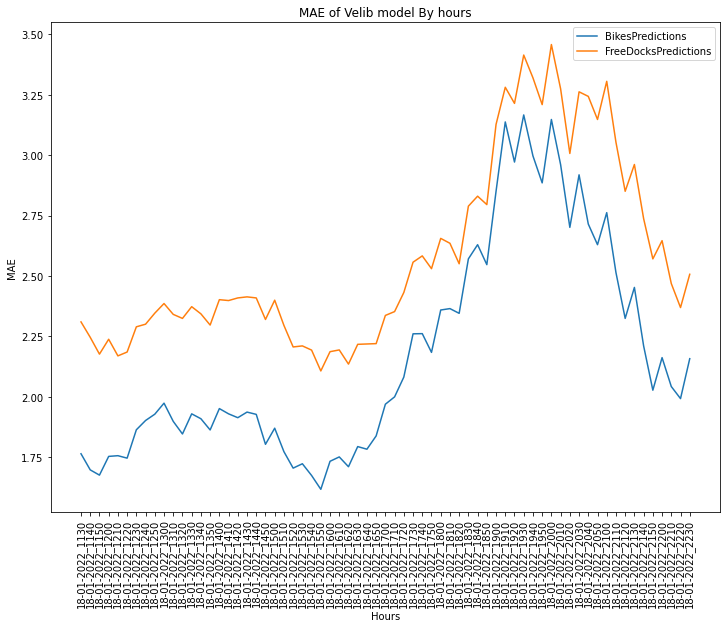

In [22]:
import matplotlib.pyplot as plt
listOfHours = ["18-01-2022_1130", "18-01-2022_1140", "18-01-2022_1150", "18-01-2022_1200", "18-01-2022_1210", "18-01-2022_1220", "18-01-2022_1230", "18-01-2022_1240", "18-01-2022_1250", "18-01-2022_1300", "18-01-2022_1310", "18-01-2022_1320", "18-01-2022_1330", "18-01-2022_1340", "18-01-2022_1350", "18-01-2022_1400", "18-01-2022_1410", "18-01-2022_1420", "18-01-2022_1430", "18-01-2022_1440", "18-01-2022_1450", "18-01-2022_1500", "18-01-2022_1510", "18-01-2022_1520", "18-01-2022_1530", "18-01-2022_1540", "18-01-2022_1550", "18-01-2022_1600", "18-01-2022_1610", "18-01-2022_1620", "18-01-2022_1630", "18-01-2022_1640", "18-01-2022_1650", "18-01-2022_1700", "18-01-2022_1710", "18-01-2022_1720", "18-01-2022_1730", "18-01-2022_1740", "18-01-2022_1750", "18-01-2022_1800", "18-01-2022_1810", "18-01-2022_1820", "18-01-2022_1830", "18-01-2022_1840", "18-01-2022_1850", "18-01-2022_1900", "18-01-2022_1910", "18-01-2022_1920", "18-01-2022_1930", "18-01-2022_1940", "18-01-2022_1950", "18-01-2022_2000", "18-01-2022_2010", "18-01-2022_2020", "18-01-2022_2030", "18-01-2022_2040", "18-01-2022_2050", "18-01-2022_2100", "18-01-2022_2110", "18-01-2022_2120", "18-01-2022_2130", "18-01-2022_2140", "18-01-2022_2150", "18-01-2022_2200", "18-01-2022_2210", "18-01-2022_2220", "18-01-2022_2230"]
plt.figure(figsize=(12, 9))
plt.plot(listOfHours, listofNbBikesPredictionMae, label="BikesPredictions")
plt.plot(listOfHours, listofFreeDocksPredictionMae, label="FreeDocksPredictions")
plt.title('MAE of Velib model By hours')
plt.xlabel('Hours')
plt.ylabel('MAE')
plt.xticks(rotation=90)
plt.legend()
plt.show()

As we can see, the MAE flictuates between 1.6 and 3.5 which is very good.

It seems that the Vélib model do good at night (from 00 AM to 9 AM)

The Vélib prediction model is worst at peak hours (6 PM to 9 PM)